In [153]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [177]:
# matrix data
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
specs = np.array(iris['species'])

In [178]:
# load iris dataset, which will serve as test dataset for building the algorithm
#iris = datasets.load_iris()

# Just to show the first 5 rows of iris dataset
#df = pd.DataFrame(iris.data, columns=iris.feature_names)
#df.head()
#X = iris.data


In [180]:
# this function is too slow 

#def squared_euc_dist(x, y, axis = -1):
#    """squared euclidean distance between vectors x and y"""
#    diff = x - y
#    return (diff**2).sum(axis)


#def row_loop_dist(M, distance_func = squared_euc_dist):
#    """finds distance matrix using row vectors of M"""
#    D = np.array([[distance_func(M[x, :], M[y, :]) for x in range(M.shape[0])] for y in range(M.shape[0])])
#    return -D


In [191]:
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

In [192]:
neg_squared_euc_dists(X)

array([[-0.00000000e+00, -2.90000000e-01, -2.60000000e-01, ...,
        -1.98900000e+01, -2.16300000e+01, -1.71400000e+01],
       [-2.90000000e-01, -0.00000000e+00, -9.00000000e-02, ...,
        -2.02400000e+01, -2.22600000e+01, -1.72500000e+01],
       [-2.60000000e-01, -9.00000000e-02, -0.00000000e+00, ...,
        -2.17300000e+01, -2.35100000e+01, -1.84800000e+01],
       ...,
       [-1.98900000e+01, -2.02400000e+01, -2.17300000e+01, ...,
        -0.00000000e+00, -3.80000000e-01, -4.10000000e-01],
       [-2.16300000e+01, -2.22600000e+01, -2.35100000e+01, ...,
        -3.80000000e-01,  5.68434189e-14, -5.90000000e-01],
       [-1.71400000e+01, -1.72500000e+01, -1.84800000e+01, ...,
        -4.10000000e-01, -5.90000000e-01, -0.00000000e+00]])

In [193]:
def softmax(X):
    """Take softmax of each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log we take later
    e_x += 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

In [194]:
def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

In [195]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

In [196]:
#def calc_perplexity(prob_matrix):
#    """Calculate the perplexity of each row 
#    of a matrix of probabilities."""
#    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
#    perplexity = 2 ** entropy
#    return perplexity


def perplexity(distances, sigmas):
    """calculate perplexity based on the P probability matrix."""
    prob_matrix = calc_prob_matrix(distances, sigmas)
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    
    return perplexity


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)



In [197]:
def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None

def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

In [198]:
def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances

In [199]:
def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P


In [200]:
p_joint(X, target_perplexity = 30)

array([[4.61927359e-12, 9.09452976e-05, 9.68656765e-05, ...,
        6.21368422e-12, 6.45636493e-12, 6.18572818e-12],
       [9.09452976e-05, 4.62956437e-12, 3.01361544e-04, ...,
        6.21882961e-12, 6.46151032e-12, 6.19087357e-12],
       [9.68656765e-05, 3.01361544e-04, 4.83107561e-12, ...,
        6.31958523e-12, 6.56226594e-12, 6.29162920e-12],
       ...,
       [6.21368422e-12, 6.21882961e-12, 6.31958523e-12, ...,
        7.80809485e-12, 1.98564543e-04, 1.18518342e-04],
       [6.45636493e-12, 6.46151032e-12, 6.56226594e-12, ...,
        1.98564543e-04, 8.29345626e-12, 1.08497838e-04],
       [6.18572818e-12, 6.19087357e-12, 6.29162920e-12, ...,
        1.18518342e-04, 1.08497838e-04, 7.75218278e-12]])

In [201]:
def symmetric_sne_grad(P, Q, Y, _):
    """Estimate the gradient of the cost with respect to Y"""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad

In [202]:
def tsne_grad(P, Q, Y, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

In [203]:
def estimate_sne(X, y, P, rng, num_iters, q_fn, grad_fn, learning_rate,
                 momentum, plot):
    """Estimates a SNE model.

    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation
    Y = rng.normal(0., 0.0001, [X.shape[0], 2])

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_fn(Y)
        # Estimate gradients with respect to Y
        grads = grad_fn(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

        # Plot sometimes
        #if plot and i % (num_iters / plot) == 0:
         #   categorical_scatter_2d(Y, y, alpha=1.0, ms=6,
          #                         show=True, figsize=(9, 6))

    return Y

In [204]:
def categorical_scatter_2d(X2D, class_idxs, ms=3, ax=None, alpha=0.1, 
                           legend=True, figsize=None, show=False, 
                           savename=None):
    ## Plot a 2D matrix with corresponding class labels: each class diff colour
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    classes = list(np.unique(class_idxs))
    markers = 'os' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0,1,len(classes)))

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(X2D[class_idxs==cls, 0], X2D[class_idxs==cls, 1], marker=mark, 
            linestyle='', ms=ms, label=str(cls), alpha=alpha, color=colors[i],
            markeredgecolor='black', markeredgewidth=0.4)
    if legend:
        ax.legend()
        
    if savename is not None:
        plt.tight_layout()
        plt.savefig(savename)
    
    if show:
        plt.show()
    
    return ax

In [205]:
# Set global parameters
NUM_POINTS = 200            # Number of samples from MNIST
CLASSES_TO_USE = [0, 1, 8]  # MNIST classes to use
PERPLEXITY = 20
SEED = 1                    # Random seed
MOMENTUM = 0.9
LEARNING_RATE = 10.
NUM_ITERS = 1000            # Num iterations to train for
#TSNE = False                # If False, Symmetric SNE
NUM_PLOTS = 5               # Num. times to plot in training


def main():
    # numpy RandomState for reproducibility
    rng = np.random.RandomState(SEED)

    # Load the first NUM_POINTS 0's, 1's and 8's from MNIST
    (n, d) = X.shape
    y = np.random.randn(n, 2)

    # Obtain matrix of joint probabilities p_ij
    P = p_joint(X, PERPLEXITY)

    # Fit SNE or t-SNE
    Y = estimate_sne(X, y, P, rng,
             num_iters=NUM_ITERS,
             q_fn=q_tsne,
             grad_fn=tsne_grad,
             learning_rate=LEARNING_RATE,
             momentum=MOMENTUM,
             plot=NUM_PLOTS)
    return Y

In [206]:
yout = main()
yout

array([[ -2.61781632, -12.52972612],
       [  1.83033851, -13.58193999],
       [  0.77042622, -14.83480598],
       [  1.398537  , -14.76668184],
       [ -2.93925043, -12.92607541],
       [ -5.1026272 , -10.51464521],
       [  0.15611773, -15.1630665 ],
       [ -1.52559338, -12.57967213],
       [  2.12343898, -15.57878578],
       [  1.23222469, -13.30981175],
       [ -4.69762799, -11.72075553],
       [ -0.18333191, -12.81208723],
       [  1.79529715, -14.0411679 ],
       [  1.83456928, -16.2206391 ],
       [ -6.49115341, -11.68286255],
       [ -6.61985419, -10.95950843],
       [ -5.56423943, -11.79180158],
       [ -2.60865782, -12.34141036],
       [ -5.64041055, -10.33638585],
       [ -4.100768  , -11.30298073],
       [ -2.88779166, -10.49243318],
       [ -3.64143543, -11.50539121],
       [ -1.06905618, -15.53395302],
       [ -1.09621043, -10.91510283],
       [  0.23240873, -11.84658717],
       [  1.62474805, -12.87186415],
       [ -1.25040604, -11.50275146],
 

In [174]:
yout.shape

(150, 2)

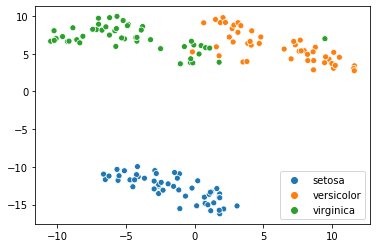

In [207]:
sns.scatterplot(yout[:,0], yout[:,1], hue = specs)

#### Test on Mnist data as well